# Preamble

This code will take NIRCam photometry images and perform apodised photometry (estimation of the flux through each NIRSpec aperture) on a given list of NIRSpec sources.

**Required packages:**
1. Astropy
2. Matplotlib
3. Numpy
4. Photutils
5. Tqdm (for progress bars)
6. ipympl (if using jupyter-lab $\ge$ v3.0)

**Things you will need to do before running the full code:**
1. Provide csv tables for each pointing (called 'visits' in the code) and for the target acquisition. The code assumes the names have a similar format, with a unique identifier for each visit. These identifiers should be listed below. The target acquisition table is assumed to have a unique name (with 'TA' somewhere in it). If needed, you can grab these files from the <a href="https://www.stsci.edu/scientific-community/software/astronomers-proposal-tool-apt">APT software</a> by following these steps:
    1. Open the apt file.
    2. Go to the relevant visit on the left, within the relevant plan.
    3. Switch to the MSA Planning Tool on the topbar.
    4. Click the Plans tab in the central window.
    5. Highlight (click on) the science plan within the Plan Selection section (usually the third of three).
    6. Once highlighted, go to the menu bar and click File..., Export..., then choose 'MSA Target Info [.csv]')
2. Each table should contain:
    - The source IDs and coordinates in RA, Dec.
    - The aperture angle
    - The offsets of the sources within the aperture (in decimal percentages).
3. Provide a list of identifiers for each photometry band image.
4. Provide a list of IDs and radii for any sources to which you'd like to apply a unique annulus size (this is used to estimate the local background - the code does sigma-clip this estimate to prevent other sources from contributing incorrectly but sometimes you may wish to adjust the sky region manually from the default and you can do this here).
5. Run the demo code at least once on a new dataset before running the full code (to be safe, you may wish to restart the kernel first to clear variables). There are a few reasons this is a good idea:
    - You may wish to check all the steps are working correctly for a new dataset.
    - Some bands have a different pixel size, and it's important to check that radii are being correctly adjusted for this (factors for each image are listed below).
    - If you have not used this code before, it can be helpful for understanding each step that's involved, especially if you need to adjust the full code for some reason.
    - You may wish to compare the aperture positions against Aladin (can be done in the APT software too, just send each science visit separately to Aladin via the MSA Planning Tool Plans tab).

# Environment Prep

In [1]:
print("Preparing environment...")

import time
import warnings

warnings.filterwarnings("ignore")
import astropy.table as tbl
import matplotlib.patches as patch
import matplotlib.pyplot as plt
import numpy as np
import photutils
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from astroquery.gaia import Gaia
from matplotlib.colors import LogNorm
from photutils.centroids import (
    centroid_1dg,
    centroid_2dg,
    centroid_com,
    centroid_quadratic,
    centroid_sources,
)
from photutils.datasets import make_4gaussians_image
from photutils.utils import calc_total_error
from tqdm.autonotebook import tqdm, trange
from photutils.background import Background2D, MedianBackground, SExtractorBackground

Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"  # Select early Data Release 3

%matplotlib widget
# %matplotlib inline

print("Done.")

Preparing environment...
Done.


In [2]:
print("Importing dataset and coordinates...")

### Define relevant lists
# List of pointings
Visits = [
    "c1-2e1n1-G235M-F170LP",
    "c1-2e1n2-G235M-F170LP",
    "c1-2e1n3-G235M-F170LP",
    "c1-2e2n1-G395M-F290LP",
    "c1-2e2n2-G395M-F290LP",
    "c1-2e2n3-G395M-F290LP",
]
# List of NIRCam images
Images = ["sw_F090W", "sw_F150W", "sw_F200W", "lw_F277W", "lw_F356W", "lw_F444W"]
# List of primary IDs
IDs = [4590, 6355, 10612]
# List of annulus radii per primary ID (identified by eye)
Radii = [(30, 50), (70, 90), (20, 40)]
# List of extensions per image
DataTypes = ["sci", "err", "con", "wht", "var_poisson", "var_rnoise", "var_flat"]

### Load all APT csv tables (info on apertures per pointing)
APT = {}
for visit in Visits:
    APT[visit] = tbl.Table.read(f"../SharedData/NIRSpec/MST_Data/2736-obs8-{visit}.csv")


# Function to grab MSA information from APT csv tables
def Grab_Gals(Input, Output, File, Row):
    ID = Input[File][Row]["ID"]
    try:
        Output[ID][File] = {}
    except KeyError:
        Output[ID] = {}
        Output[ID][File] = {}
    finally:
        Output[ID][File]["RA"] = Input[File][Row]["Source RA (Degrees)"] * u.deg
        Output[ID][File]["Dec"] = Input[File][Row]["Source Dec (Degrees)"] * u.deg
        Output[ID][File]["Angle"] = Input[File][Row]["Aperture PA (Degrees)"] * u.deg
        Output[ID][File]["Offset_x"] = (
            Input[File][Row]["Offset (x)"]
        ) * u.dimensionless_unscaled
        Output[ID][File]["Offset_y"] = (
            Input[File][Row]["Offset (y)"]
        ) * u.dimensionless_unscaled
    return Output


# Grab target acquisition information
APT["Align"] = tbl.Table.read("../SharedData/NIRSpec/MST_Data/2736-obs8-1-TA.csv")
Align = {}
for x in range(0, len(APT["Align"]), 1):
    Align = Grab_Gals(APT, Align, "Align", x)
    
# Grab complete longlist of galaxies
Longlist = {}
for visit in Visits:
    for x in range(0, len(APT[visit]), 1):
        Longlist = Grab_Gals(APT, Longlist, visit, x)


# Grab image data
print("Importing images...")
for image in tqdm(Images, desc="Images"):
    Longlist[image] = {}
    hdu_file = fits.open(
        f"../SharedData/NIRSpec/MST_Data/FSun_SMACSJ0723_{image}_modB_i2d.fits"
    )
    Longlist[image]["header"] = hdu_file[0].header
    for x, dtyp in tqdm(
        zip(np.arange(1, 8, 1), DataTypes), desc="Extensions", leave=False
    ):
        Longlist[image][dtyp] = {}
        Longlist[image][dtyp]["data"] = np.ma.array(
            hdu_file[x].data, mask=np.isnan(hdu_file[x].data)
        )
        Longlist[image][dtyp]["header"] = hdu_file[x].header
    hdu_file.close()

print("Done.")

Importing dataset and coordinates...
Importing images...


Images:   0%|          | 0/6 [00:00<?, ?it/s]

Extensions: 0it [00:00, ?it/s]

Extensions: 0it [00:00, ?it/s]

Extensions: 0it [00:00, ?it/s]

Extensions: 0it [00:00, ?it/s]

Extensions: 0it [00:00, ?it/s]

Extensions: 0it [00:00, ?it/s]

Done.


# Full Code (RUNME)

Generalised code for all galaxies (see demo section for explanation of steps).

In [3]:
print("Defining functions...")

# Function to find aperture corner coordinates
def Find_Aperture(
    Reference, Reference_Physical, Dimensions, frame_aperture_to_image, wcs
):
    offset_aper = np.array(
        [[Reference[0], Reference[1]], [0, 0], [1, 0], [1, 1], [0, 1]]
    )
    offset_aper_rel = offset_aper - offset_aper[0]
    offset_aper_deg = np.array([item * Dimensions for item in offset_aper_rel])
    offset_image_deg = np.array(
        [np.matmul(item, frame_aperture_to_image) for item in offset_aper_deg]
    )
    offset_image = np.array(
        [
            item * np.array([1 / np.cos(Reference_Physical[1]), 1])
            for item in offset_image_deg
        ]
    )
    aperture_image = (
        np.array([Reference_Physical - item * u.degree for item in offset_image])
        * u.degree
    )
    aperture_image_sky = np.array(
        [SkyCoord(ra=item[0], dec=item[1]) for item in aperture_image]
    )
    aperture_pixel = np.array([wcs.world_to_pixel(item) for item in aperture_image_sky])
    reference_pixel = aperture_pixel[0]
    aperture_corners = aperture_pixel[1:5].transpose()
    return reference_pixel, aperture_corners


# Function to find centre of aperture from corner coordinates
def polygon_area(xs, ys):
    """https://en.wikipedia.org/wiki/Centroid#Of_a_polygon"""
    # https://stackoverflow.com/a/30408825/7128154
    return 0.5 * (np.dot(xs, np.roll(ys, 1)) - np.dot(ys, np.roll(xs, 1)))


# Function to find area of aperture from corner coordinates
def polygon_centroid(xs, ys):
    """https://en.wikipedia.org/wiki/Centroid#Of_a_polygon"""
    xy = np.array([xs, ys])
    c = np.dot(
        xy + np.roll(xy, 1, axis=1), xs * np.roll(ys, 1) - np.roll(xs, 1) * ys
    ) / (6 * polygon_area(xs, ys))
    return c


# Function to define dimensions of aperture
def aperture_define(corners, angle):
    centroid = polygon_centroid(corners[0], corners[1])
    width = np.sqrt(
        (corners[0][1] - corners[0][0]) ** 2 + (corners[1][1] - corners[1][0]) ** 2
    )
    height = np.sqrt(
        (corners[0][2] - corners[0][1]) ** 2 + (corners[1][2] - corners[1][1]) ** 2
    )
    aperture_object = photutils.aperture.RectangularAperture(
        centroid,
        width,
        height,
        theta=angle,
    )
    return aperture_object, centroid, width, height


# Function to grab Target Acquisition centroids
def TA_centroids(image, wcs):
    x_init = y_init = []
    for ID in Align.keys():
        pixels = wcs.world_to_pixel(
            SkyCoord(ra=Align[ID]["Align"]["RA"], dec=Align[ID]["Align"]["Dec"])
        )
        x_init = x_init + [pixels[0]]
        y_init = y_init + [pixels[1]]
    # Run through centroid fitting
    x_init = np.array(x_init)
    y_init = np.array(y_init)
    x, y = centroid_sources(
        Longlist[image]["sci"]["data"],
        x_init,
        y_init,
        box_size=21,
        centroid_func=centroid_2dg,
    )
    return x, y, x_init, y_init


# Function to find shift factor
def find_shift(x, y, x_init, y_init):
    x_shift = x - x_init
    y_shift = y - y_init
    return x_shift, y_shift


# Function to correct shift
def shift_correct(x_shift, y_shift, x_init, y_init):
    x_subtr = x_init + np.mean(x_shift)
    y_subtr = y_init + np.mean(y_shift)
    return x_subtr, y_subtr


# Function to find equation of a line
def linear_equation(x1, x2, y1, y2):
    m = (y1 - y2) / (x1 - x2)
    c = -m * x1 + y1
    return m, c


# Function to find intersect between two lines
def intersect(m1, c1, m2, c2):
    x_int = (c2 - c1) / (m1 - m2)
    y_int = (m1 * x_int) + c1
    return x_int, y_int


# Function to locate scale centre
def scale_centre(x, y, x_subtr, y_subtr):
    x_ints = y_ints = []
    for i in range(0, len(x), 1):
        for j in range(0, len(y), 1):
            if i != j:
                mi, ci = linear_equation(x[i], x_subtr[i], y[i], y_subtr[i])
                mj, cj = linear_equation(x[j], x_subtr[j], y[j], y_subtr[j])
                x_int, y_int = intersect(mi, ci, mj, cj)
                x_ints = x_ints + [x_int]
                y_ints = y_ints + [y_int]
    x_int = np.mean(x_ints)
    y_int = np.mean(y_ints)
    return x_int, y_int


# Function to find scale values
def find_scale(xs, ys, x_offs, y_offs, x_int, y_int):
    x_intarr = np.full(len(xs), x_int)
    x_dists = xs - x_intarr
    x_offdists = x_offs - x_intarr
    x_scalearr = np.divide(x_offdists, x_dists)
    x_scale = np.mean(x_scalearr)
    y_intarr = np.full(len(ys), y_int)
    y_dists = ys - y_intarr
    y_offdists = y_offs - y_intarr
    y_scalearr = np.divide(y_offdists, y_dists)
    y_scale = np.mean(y_scalearr)
    return x_scale, y_scale


# Function to correct scale
def scale_correct(xs, ys, x_shift, y_shift, x_int, y_int):
    x_new = (xs - x_int) * x_shift + x_int
    y_new = (ys - y_int) * y_shift + y_int
    return x_new, y_new


# Function to oversee calculation of shift + scale correction
def shift_and_scale(image, wcs):
    x, y, x_init, y_init = TA_centroids(image, wcs)
    x_shift, y_shift = find_shift(x, y, x_init, y_init)
    x_subtr, y_subtr = shift_correct(x_shift, y_shift, x_init, y_init)
    x_int, y_int = scale_centre(x, y, x_subtr, y_subtr)
    x_scale, y_scale = find_scale(x_subtr, y_subtr, x, y, x_int, y_int)
    return x_shift, x_scale, y_shift, y_scale, x_int, y_int


# Function to perform apodised photometry
def Find_Photometry(
    source_location, radius, aperture, data, error, bkg_flag, err_flag, image
):
    annulus = photutils.aperture.CircularAnnulus(
        source_location, r_in=radius[0], r_out=radius[1]
    )
    if bkg_flag == False:
        annu_stats = photutils.ApertureStats(data, annulus)
        bkg_value = annu_stats.mean
        phot_table = photutils.aperture_photometry(data, aperture)
        for col in phot_table.colnames:
            phot_table[col].info.format = "%.8g"
        apflux = phot_table["aperture_sum"][0]
        aperture_area = aperture.area_overlap(data)
        total_bkg = bkg_value * aperture_area
        phot_bkgsub = apflux - total_bkg
    elif bkg_flag == True:
        sigclip = SigmaClip(sigma=3.0, maxiters=10)
        aper_stats = photutils.ApertureStats(data, aperture, sigma_clip=None)
        bkg_stats = photutils.ApertureStats(data, annulus, sigma_clip=sigclip)
        bkg_value = bkg_stats.median
        total_bkg = bkg_value * aper_stats.sum_aper_area.value
        apflux = aper_stats.sum
        phot_bkgsub = apflux - total_bkg
    if err_flag == False:
        phot_table = photutils.aperture_photometry(data, aperture, error=error)
        for col in phot_table.colnames:
            phot_table[col].info.format = "%.8g"
        phot_err = phot_table["aperture_sum_err"][0]
    elif err_flag == True:
        effective_gain = Longlist[image]["header"]["EFFEXPTM"]  # electrons/s x seconds
        bkg_error = calc_total_error(data, error, effective_gain)
        phot_table = photutils.aperture_photometry(data, aperture, error=bkg_error)
        for col in phot_table.colnames:
            phot_table[col].info.format = "%.8g"  # for consistent table output
        phot_err = phot_table["aperture_sum_err"][0]
    return apflux, bkg_value, phot_bkgsub, phot_err


# Function to execute code
def Apodised_Photometry(
    bkg_flag=True, err_flag=False
):  # bkg_flag for sigma-clipping, err_flag for Poisson error
    # Required variables
    aperture_phys_width = (0.27 * u.arcsec).to(u.degree)
    aperture_phys_height = (0.53 * u.arcsec).to(u.degree)
    aperture_phys_dims = (
        np.array([aperture_phys_width.value, aperture_phys_height.value])
        * aperture_phys_height.unit
    )
    aperture_illum_width = (0.20 * u.arcsec).to(u.degree)
    aperture_illum_height = (0.46 * u.arcsec).to(u.degree)
    aperture_illum_dims = (
        np.array([aperture_illum_width.value, aperture_illum_height.value])
        * aperture_illum_height.unit
    )
    center_offset = np.array([0.5, 0.5])

    # Looping through images, visits and IDs
    offsetrows = []
    for image in tqdm(Images, desc="Images"):
        wcs = WCS(Longlist[image]["sci"]["header"])
        # Where to save photometry for later averaging
        Longlist[image]["Averages"] = {}
        # Finding offset+shift correction for image
        x_shift, x_scale, y_shift, y_scale, x_int, y_int = shift_and_scale(image, wcs)
        for visit in tqdm(Visits, desc="Visits", leave=False):
            Longlist[image][visit] = {}
            rows = []
            for x in trange(len(Longlist) - 6, desc="IDs", leave=False):
                # More required objects
                ID = np.array(list(Longlist.keys()))[x].astype(int)
                try:
                    aperture_theta = Longlist[ID][visit]["Angle"]
                    frame_aperture_to_image = np.array(
                        [
                            [np.cos(aperture_theta), -np.sin(aperture_theta)],
                            [np.sin(aperture_theta), np.cos(aperture_theta)],
                        ]
                    )
                    frame_image_to_aperture = np.array(
                        [
                            [np.cos(-aperture_theta), -np.sin(-aperture_theta)],
                            [np.sin(-aperture_theta), np.cos(-aperture_theta)],
                        ]
                    )
                    source_coords_phys = (
                        np.array(
                            [
                                Longlist[ID][visit]["RA"].value,
                                Longlist[ID][visit]["Dec"].value,
                            ]
                        )
                        * Longlist[ID][visit]["Dec"].unit
                    )
                    source_offset = [
                        1 - Longlist[ID][visit]["Offset_x"],
                        Longlist[ID][visit]["Offset_y"],
                    ]
                    # Physical aperture
                    source_coords_pixels, aperture_phys_corners = Find_Aperture(
                        source_offset,
                        source_coords_phys,
                        aperture_phys_dims,
                        frame_aperture_to_image,
                        wcs,
                    )
                    (
                        aperture_phys,
                        aperture_phys_centroid,
                        aperture_phys_width_pixel,
                        aperture_phys_height_pixel,
                    ) = aperture_define(aperture_phys_corners, aperture_theta)
                    # # Illuminated aperture
                    # aperture_centroid_world = (
                    #     np.array(
                    #         wcs.pixel_to_world_values(
                    #             aperture_phys_centroid[0], aperture_phys_centroid[1]
                    #         )
                    #     )
                    #     * u.degree
                    # )
                    # centroid_coords_pixels, aperture_illum_corners = Find_Aperture(
                    #     center_offset, aperture_centroid_world, aperture_illum_dims, frame_aperture_to_image, wcs
                    # )
                    # (
                    #     aperture_illum,
                    #     aperture_illum_centroid,
                    #     aperture_illum_width_pixel,
                    #     aperture_illum_height_pixel,
                    # ) = aperture_define(aperture_illum_corners, aperture_theta)
                    # Shift-corrected aperture
                    aperture_shift_x, aperture_shift_y = shift_correct(
                        x_shift,
                        y_shift,
                        aperture_phys_centroid[0],
                        aperture_phys_centroid[1],
                    )
                    # aperture_shift_centroid_world = (
                    #     np.array(
                    #         wcs.pixel_to_world_values(aperture_shift_x, aperture_shift_y)
                    #     )
                    #     * u.degree
                    # )
                    # centroid_shift_coords_pixels, aperture_shift_corners = Find_Aperture(
                    #     center_offset, aperture_shift_centroid_world, aperture_illum_dims, frame_aperture_to_image, wcs
                    # )
                    # (
                    #     aperture_shift,
                    #     aperture_shift_centroid,
                    #     aperture_shift_width_pixel,
                    #     aperture_shift_height_pixel,
                    # ) = aperture_define(aperture_shift_corners, aperture_theta)
                    # Shift-corrected aperture
                    aperture_scale_x, aperture_scale_y = scale_correct(
                        aperture_shift_x,
                        aperture_shift_y,
                        x_scale,
                        y_scale,
                        x_int,
                        y_int,
                    )
                    aperture_scale_centroid_world = (
                        np.array(
                            wcs.pixel_to_world_values(
                                aperture_scale_x, aperture_scale_y
                            )
                        )
                        * u.degree
                    )
                    (
                        centroid_scale_coords_pixels,
                        aperture_scale_corners,
                    ) = Find_Aperture(
                        center_offset,
                        aperture_scale_centroid_world,
                        aperture_illum_dims,
                        frame_aperture_to_image,
                        wcs,
                    )
                    (
                        aperture_scale,
                        aperture_scale_centroid,
                        aperture_scale_width_pixel,
                        aperture_scale_height_pixel,
                    ) = aperture_define(aperture_scale_corners, aperture_theta)
                    # Shift-corrected source
                    source_shift_x, source_shift_y = shift_correct(
                        x_shift,
                        y_shift,
                        source_coords_pixels[0],
                        source_coords_pixels[1],
                    )
                    # Scale-corrected source
                    source_scale_x, source_scale_y = scale_correct(
                        source_shift_x,
                        source_shift_y,
                        x_scale,
                        y_scale,
                        x_int,
                        y_int,
                    )
                    # Saving data to table
                    Longlist[image][visit][ID] = {}
                    Longlist[image][visit][ID]["Source_Pixel_x"] = source_coords_pixels[
                        0
                    ]
                    Longlist[image][visit][ID]["Source_Pixel_y"] = source_coords_pixels[
                        1
                    ]
                    Longlist[image][visit][ID]["Source_Shifted_x"] = source_shift_x
                    Longlist[image][visit][ID]["Source_Shifted_y"] = source_shift_y
                    Longlist[image][visit][ID]["Source_Scaled_x"] = source_scale_x
                    Longlist[image][visit][ID]["Source_Scaled_y"] = source_scale_y
                    Longlist[image][visit][ID][
                        "Aperture_Pixel_x"
                    ] = aperture_phys_centroid[0]
                    Longlist[image][visit][ID][
                        "Aperture_Pixel_y"
                    ] = aperture_phys_centroid[1]
                    Longlist[image][visit][ID]["Aperture_Shifted_x"] = aperture_shift_x
                    Longlist[image][visit][ID]["Aperture_Shifted_y"] = aperture_shift_y
                    Longlist[image][visit][ID]["Aperture_Scaled_x"] = aperture_scale_x
                    Longlist[image][visit][ID]["Aperture_Scaled_y"] = aperture_scale_y
                    # Apodised photometry
                    try:
                        data = Longlist[image]["sci"]["data"]
                        error = Longlist[image]["err"]["data"]
                        radius = (30, 50)
                        for case, replace in zip(IDs, Radii):
                            if case == ID:
                                radius = replace
                                break
                        (apflux, bkg_value, phot_bkgsub, phot_err,) = Find_Photometry(
                            np.array([source_scale_x, source_scale_y]),
                            radius,
                            aperture_scale,
                            data,
                            error,
                            bkg_flag,
                            err_flag,
                            image,
                        )
                        Longlist[image][visit][ID]["Aperture_Flux"] = apflux
                        Longlist[image][visit][ID]["Background"] = bkg_value
                        Longlist[image][visit][ID]["Final_Flux"] = phot_bkgsub
                        Longlist[image][visit][ID]["Final_Flux_Error"] = phot_err
                        # Save values for later averaging
                        try:
                            Longlist[image]["Averages"][ID]["Fluxaverage"][
                                visit
                            ] = Longlist[image][visit][ID]["Aperture_Flux"]
                        except KeyError:
                            Longlist[image]["Averages"][ID] = {}
                            Longlist[image]["Averages"][ID]["Fluxaverage"] = {}
                            Longlist[image]["Averages"][ID]["Backaverage"] = {}
                            Longlist[image]["Averages"][ID]["Finalaverage"] = {}
                            Longlist[image]["Averages"][ID]["Finalerr"] = {}
                            Longlist[image]["Averages"][ID]["Fluxaverage"][
                                visit
                            ] = Longlist[image][visit][ID]["Aperture_Flux"]
                        finally:
                            Longlist[image]["Averages"][ID]["Backaverage"][
                                visit
                            ] = Longlist[image][visit][ID]["Background"]
                            Longlist[image]["Averages"][ID]["Finalaverage"][
                                visit
                            ] = Longlist[image][visit][ID]["Final_Flux"]
                            Longlist[image]["Averages"][ID]["Finalerr"][visit] = (
                                Longlist[image][visit][ID]["Final_Flux_Error"]
                            ) ** 2
                    except IndexError:
                        continue
                except KeyError:
                    continue
                else:
                    rows.append(
                        [
                            ID,
                            Longlist[ID][visit]["RA"].value,
                            Longlist[ID][visit]["Dec"].value,
                            Longlist[ID][visit]["Angle"].value,
                            Longlist[ID][visit]["Offset_x"],
                            Longlist[ID][visit]["Offset_y"],
                            Longlist[image][visit][ID]["Source_Pixel_x"],
                            Longlist[image][visit][ID]["Source_Pixel_y"],
                            Longlist[image][visit][ID]["Source_Shifted_x"],
                            Longlist[image][visit][ID]["Source_Shifted_y"],
                            Longlist[image][visit][ID]["Source_Scaled_x"],
                            Longlist[image][visit][ID]["Source_Scaled_y"],
                            Longlist[image][visit][ID]["Aperture_Pixel_x"],
                            Longlist[image][visit][ID]["Aperture_Pixel_y"],
                            Longlist[image][visit][ID]["Aperture_Shifted_x"],
                            Longlist[image][visit][ID]["Aperture_Shifted_y"],
                            Longlist[image][visit][ID]["Aperture_Scaled_x"],
                            Longlist[image][visit][ID]["Aperture_Scaled_y"],
                            aperture_scale_width_pixel,
                            aperture_scale_height_pixel,
                            radius[0],
                            radius[1],
                            Longlist[image][visit][ID]["Aperture_Flux"],
                            Longlist[image][visit][ID]["Background"],
                            Longlist[image][visit][ID]["Final_Flux"],
                            Longlist[image][visit][ID]["Final_Flux_Error"],
                        ]
                    )
            Photometry_Table = tbl.Table(
                rows=rows,
                names=(
                    "ID",
                    "RA",
                    "Dec",
                    "Angle",
                    "Offset_x",
                    "Offset_y",
                    "Source_Pixel_x",
                    "Source_Pixel_y",
                    "Source_Shifted_x",
                    "Source_Shifted_y",
                    "Source_Scaled_x",
                    "Source_Scaled_y",
                    "Aperture_Pixel_x",
                    "Aperture_Pixel_y",
                    "Aperture_Shifted_x",
                    "Aperture_Shifted_y",
                    "Aperture_Scaled_x",
                    "Aperture_Scaled_y",
                    "Aperture_Width",
                    "Aperture_Height",
                    "Annulus_Radius_In",
                    "Annulus_Radius_Out",
                    "Aperture_Flux",
                    "Background_per_Pixel",
                    "Final_Flux",
                    "Final_Flux_Error",
                ),
            )
            Photometry_Table.write(
                f"../Working_Directory/SMACS_Targets/{image}_{visit}.fits"
            )
        # Average the fluxes per pointing
        summaryrows = []
        for galaxy in tqdm(
            Longlist[image]["Averages"].keys(),
            desc="Averaging all pointings",
            leave=False,
        ):
            Fluxaverage = np.sum(
                list(Longlist[image]["Averages"][galaxy]["Fluxaverage"].values())
            ) / len(Longlist[image]["Averages"][galaxy]["Fluxaverage"].keys())
            Backaverage = np.sum(
                list(Longlist[image]["Averages"][galaxy]["Backaverage"].values())
            ) / len(Longlist[image]["Averages"][galaxy]["Backaverage"].keys())
            Finalaverage = np.sum(
                list(Longlist[image]["Averages"][galaxy]["Finalaverage"].values())
            ) / len(Longlist[image]["Averages"][galaxy]["Finalaverage"].keys())
            Finalerr = np.sqrt(
                np.sum(list(Longlist[image]["Averages"][galaxy]["Finalerr"].values()))
            )
            visitdummy = list(
                Longlist[image]["Averages"][galaxy]["Finalaverage"].keys()
            )[0]
            summaryrows.append(
                [
                    galaxy,
                    Longlist[galaxy][visitdummy]["RA"].value,
                    Longlist[galaxy][visitdummy]["Dec"].value,
                    Fluxaverage,
                    Backaverage,
                    Finalaverage,
                    Finalerr,
                ]
            )
        Photometry_Table_Summary = tbl.Table(
            rows=summaryrows,
            names=(
                "ID",
                "RA",
                "Dec",
                "Average_Aperture_Flux",
                "Average_Background_per_Pixel",
                "Average_Final_Flux",
                "Average_Final_Flux_Error",
            ),
        )
        Photometry_Table_Summary.write(
            f"../Working_Directory/SMACS_Targets/{image}_summary.fits"
        )
        offsetrows.append([image, np.mean(x_shift), np.mean(y_shift), x_scale, y_scale, x_int, y_int])
    Info_Table = tbl.Table(
        rows=offsetrows,
        names=(
            "Image",
            "Shift_RA",
            "Shift_Dec",
            "Scale_RA",
            "Scale_Dec",
            "Scale_Origin_RA",
            "Scale_Origin_Dec",
        ),
    )
    Info_Table.write(f"../Working_Directory/SMACS_Targets/offset_info.fits")
    return


print("Done.")

Defining functions...
Done.


In [4]:
print("Calculating apodised photometry...")

Apodised_Photometry()

print("Done.")

Calculating apodised photometry...


Images:   0%|          | 0/6 [00:00<?, ?it/s]

Visits:   0%|          | 0/6 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

Averaging all pointings:   0%|          | 0/45 [00:00<?, ?it/s]

Visits:   0%|          | 0/6 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

Averaging all pointings:   0%|          | 0/45 [00:00<?, ?it/s]

Visits:   0%|          | 0/6 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

Averaging all pointings:   0%|          | 0/45 [00:00<?, ?it/s]

Visits:   0%|          | 0/6 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

Averaging all pointings:   0%|          | 0/42 [00:00<?, ?it/s]

Visits:   0%|          | 0/6 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

Averaging all pointings:   0%|          | 0/42 [00:00<?, ?it/s]

Visits:   0%|          | 0/6 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

IDs:   0%|          | 0/57 [00:00<?, ?it/s]

Averaging all pointings:   0%|          | 0/42 [00:00<?, ?it/s]

Done.


# Demo Calculations (illustration of core principles)

## Plotting the image

Here, we illustrate the principles of the apodised photometry for a **test galaxy 10612** in the **image F200W** for the **pointing c1-2e1n1**.

We begin by **plotting the image** for demonstration purposes, alongside image relevant statistics.

Calculating image statistics...
Min: -0.12125086310869965
Max: 669.3965685404428
Mean: 0.037002765291035744
Stdev: 1.4572941231712067
Q01: -0.013419023356957127
Q99: 0.3795285624912643
Plotting raw image...
Done.


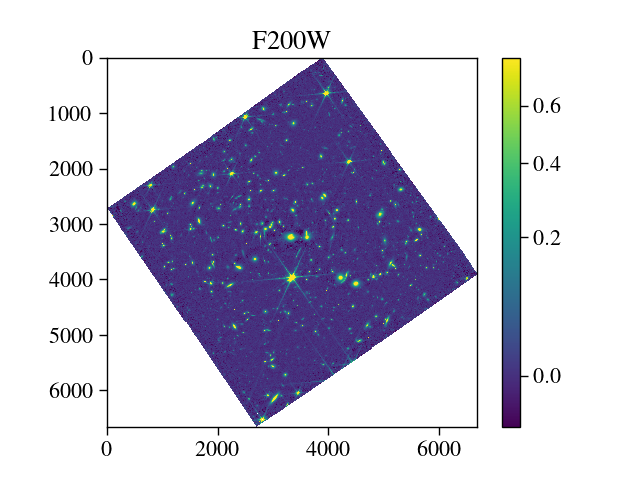

In [3]:
print("Calculating image statistics...")

print("Min:", np.min(Longlist["sw_F200W"]["sci"]["data"]))
print("Max:", np.max(Longlist["sw_F200W"]["sci"]["data"]))
print("Mean:", np.mean(Longlist["sw_F200W"]["sci"]["data"]))
print("Stdev:", np.std(Longlist["sw_F200W"]["sci"]["data"]))
print(
    "Q01:",
    np.percentile(
        Longlist["sw_F200W"]["sci"]["data"][
            ~np.isnan(Longlist["sw_F200W"]["sci"]["data"])
        ],
        [1],
    )[0],
)
print(
    "Q99:",
    np.percentile(
        Longlist["sw_F200W"]["sci"]["data"][
            ~np.isnan(Longlist["sw_F200W"]["sci"]["data"])
        ],
        [99],
    )[0],
)

print("Plotting raw image...")

plt.close("all")
norm = simple_norm(Longlist["sw_F200W"]["sci"]["data"], "sqrt", percent=99)
plt.imshow(Longlist["sw_F200W"]["sci"]["data"], norm=norm, interpolation="nearest")
plt.colorbar()
plt.title("F200W")

print("Done.")

## Overlaying the Aperture and Annulus

Next, we demonstrate the **plotting of the aperture** in the image, as well as **the annulus** that would be used to subtract the background. The four corners of the aperture are required for this step, and we have provided the rough source coordinates for reference. All values were measured by eye from Aladin (not the final approach, demo purposes only).

Calculating test data...

Defining test aperture...
Aperture: RectangularAperture
positions: [3074.29064651, 5673.84607909]
w: 8.955026521457546
h: 17.851109209234128
theta: -0.8937882102207705

Defining annulus...
Aperture: CircularAnnulus
positions: [3074.29064651, 5673.84607909]
r_in: 20.0
r_out: 40.0

Plotting test aperture...
Done


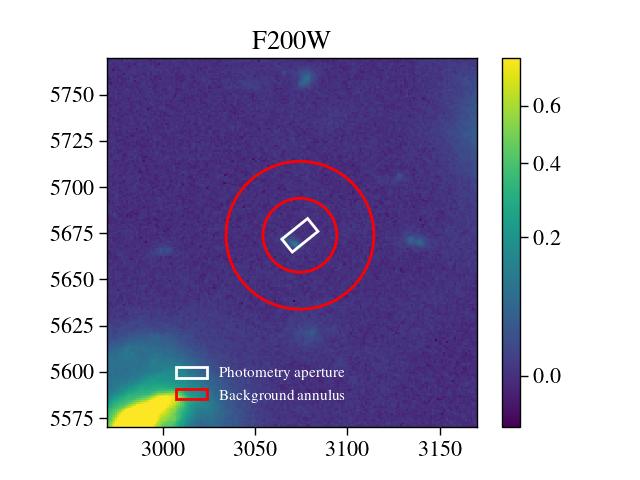

In [4]:
print("Calculating test data...")

# Test coordinates, measured by eye, source 10612, image F200W, visit c1-2e1n1
source_coords_test = (3071.48, 5670.81)
aperture_coords_test = [
    (3078.42, 5682.96),
    (3084.03, 5675.98),
    (3070.17, 5664.73),
    (3064.55, 5671.72),
]

# # Test coordinates, measured by eye, source 9483, image F200W, visit c1-2e1n1
# source_coords_test = (4312, 3923)
# aperture_coords_test = [
#     (4309, 3930),
#     (4315, 3923),
#     (4301, 3912),
#     (4295, 3919),
# ]

# Functions to calculate area and centre of aperture from corner coordinates
def polygon_area(xs, ys):
    """https://en.wikipedia.org/wiki/Centroid#Of_a_polygon"""
    # https://stackoverflow.com/a/30408825/7128154
    return 0.5 * (np.dot(xs, np.roll(ys, 1)) - np.dot(ys, np.roll(xs, 1)))


def polygon_centroid(xs, ys):
    """https://en.wikipedia.org/wiki/Centroid#Of_a_polygon"""
    xy = np.array([xs, ys])
    c = np.dot(
        xy + np.roll(xy, 1, axis=1), xs * np.roll(ys, 1) - np.roll(xs, 1) * ys
    ) / (6 * polygon_area(xs, ys))
    return c


print("\nDefining test aperture...")

# Find aperture dimensions
aperture_points = np.array(aperture_coords_test).transpose().tolist()
aperture_centroid = polygon_centroid(aperture_points[0], aperture_points[1])
aperture_width = np.sqrt(
    (aperture_points[0][1] - aperture_points[0][0]) ** 2
    + (aperture_points[1][1] - aperture_points[1][0]) ** 2
)
aperture_height = np.sqrt(
    (aperture_points[0][2] - aperture_points[0][1]) ** 2
    + (aperture_points[1][2] - aperture_points[1][1]) ** 2
)
aperture_theta = np.arctan(
    (aperture_points[1][1] - aperture_points[1][0])
    / (aperture_points[0][1] - aperture_points[0][0])
)

# Define aperture for photutils
aperture = photutils.aperture.RectangularAperture(
    aperture_centroid, aperture_width, aperture_height, theta=aperture_theta
)
print(aperture)

print("\nDefining annulus...")

# Define annulus for photutils
annulus = photutils.aperture.CircularAnnulus(aperture_centroid, r_in=20, r_out=40)
print(annulus)

print("\nPlotting test aperture...")

plt.close("all")
norm = simple_norm(Longlist["sw_F200W"]["sci"]["data"], "sqrt", percent=99)
plt.imshow(Longlist["sw_F200W"]["sci"]["data"], norm=norm, interpolation="nearest")
plt.xlim(2970, 3170)
plt.ylim(5570, 5770)

ap_patches = aperture.plot(color="white", lw=2, label="Photometry aperture")
ann_patches = annulus.plot(color="red", lw=2, label="Background annulus")
handles = (ap_patches[0], ann_patches[0])
plt.legend(
    loc=(0.17, 0.05),
    facecolor="#458989",
    labelcolor="white",
    handles=handles,
    prop={"weight": "bold", "size": 11},
)
plt.colorbar()
plt.title("F200W")

print("Done")

## Interpretting the 'Source Offset' Parameter

Ultimately, we want to **use the data from the CSV table** (imported in Environment Prep) to find our apertures, rather than measuring individually by eye from Aladin, as this would be time-consuming and error-prone. However, to do this, there is a huge snag, which is that very little information is actually provided to us, and we will require some ingenuity to circumvent this.

**We have immediate access to the following information**:
- The source coordinates in RA, Dec (CSV)
- The source offset (x,y) within the aperture from 0 to 1 (CSV)
- The aperture position angle in degrees (CSV)
- The aperture dimensions in arcseconds (STSci website)

Essentially, we will need to use the source coordinates as a reference for the aperture's sky position. Assuming the source offset is a percentage from the corner of the aperture, we can then use the angular size and rotation of the aperture to get a precise location.

**Let us show that the offset is likely to be a percentage from the aperture corner.** We plot our test galaxy below using the measured pixel coordinates compared to the predicted CSV offsets. If we see only roughly complete overlap (allowing for errors in the pixel estimates), then our interpretation is likely correct.

Comparing extracted vs planned offsets...
Extracted:  [0.56763856 0.27072834]
Planned:  [<Quantity 0.404>, <Quantity 0.727>]
Done.


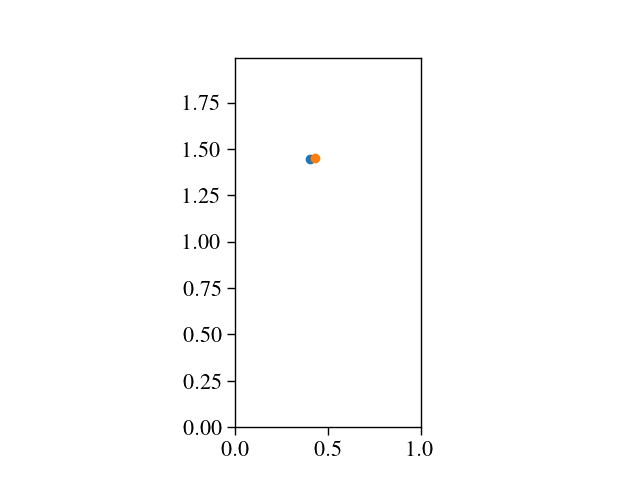

In [5]:
print("Comparing extracted vs planned offsets...")

# Source offset from aperture centre in pixel coordinates
source_offset_old = source_coords_test - aperture_centroid
# Rotate into aperture frame i.e. undo aperture rotation
frame_image_to_aperture = np.array(
    [
        [np.cos(aperture_theta), -np.sin(aperture_theta)],
        [np.sin(aperture_theta), np.cos(aperture_theta)],
    ]
)
source_offset_new = np.matmul(source_offset_old, frame_image_to_aperture)
# Express as percentage of aperture dimensions
source_offset_rel = source_offset_new * np.array(
    [1 / aperture_width, 1 / aperture_height]
)
# Finally, calculate offset from corner of aperture
source_offset = source_offset_rel + np.array([0.5, 0.5])
print("Extracted: ", source_offset)
print(
    "Planned: ",
    [
        Longlist[10612]["c1-2e1n1-G235M-F170LP"]["Offset_x"],
        Longlist[10612]["c1-2e1n1-G235M-F170LP"]["Offset_y"],
    ],
)

# Plot this visually
plt.close("all")
plt.scatter(
    Longlist[10612]["c1-2e1n1-G235M-F170LP"]["Offset_x"],
    (Longlist[10612]["c1-2e1n1-G235M-F170LP"]["Offset_y"])
    * (aperture_height / aperture_width),
)
plt.scatter(1 - source_offset[0], (1 - source_offset[1]) * (aperture_height / aperture_width))
plt.xlim(0, 1)
plt.ylim(0, (aperture_height / aperture_width))
plt.gca().set_aspect("equal", adjustable="box")

print("Done.")

## Constructing the Aperture from the CSV File

Great, this works!

**To construct our aperture, we will follow these steps:**
1. Create a unit square aperture with the source located at the origin (*requires source offset*)
2. Transform the square aperture into the correct rectangular aperture (*requires aperture dimensions*)
3. Rotate from the aperture frame to the image frame (*requires aperture position angle*)
4. Change aperture's dimensions from physical degrees to RA, Dec (*requires source Dec*)
5. Shift the origin from the source to the image, to get the correct sky position (*requires source RA, Dec*)
6. Transform coordinates from RA, Dec to pixels, to allow for final photometry.

However, *we must be careful to differentiate between the physical aperture and the illuminated aperture.* The **illuminated aperture** is relevant for our **final photometry** and is smaller, but the **offsets** are only relevant for the **physical aperture**. This means, once we have the aperture centre, we will need to *repeat the above steps for the illuminated aperture* (this time using the aperture centre as our origin for simplicity).

Constructing physical aperture...
Aperture: RectangularAperture
positions: [3073.00941849, 5672.74081306]
w: 9.002029186945014
h: 17.667123193108207
theta: 308.9642034 deg

Constructing illuminated aperture...
Aperture: RectangularAperture
positions: [3073.00943122, 5672.7408055 ]
w: 6.668164704449705
h: 15.333719198711586
theta: 308.9642034 deg

Defining annulus...
Aperture: CircularAnnulus
positions: [3070.42726913, 5669.55291457]
r_in: 20.0
r_out: 40.0

Plotting aperture...
Done.


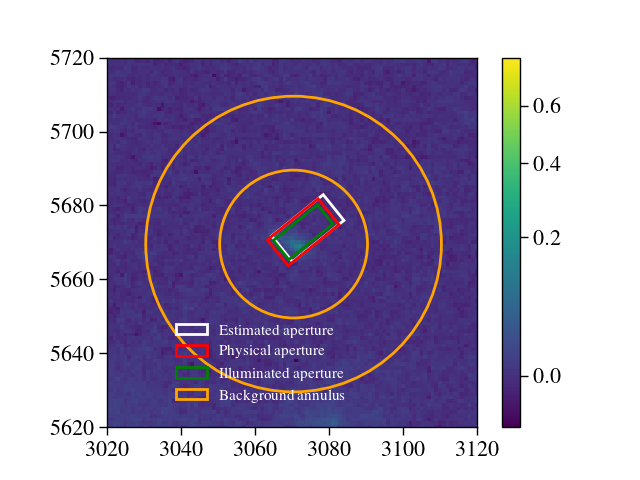

In [6]:
print("Constructing physical aperture...")

# From now on, we want to calculate fluxes with the accurate APT offset.

# Function to find aperture corner coordinates
def Find_Aperture(Reference, Reference_Physical, Dimensions):
    # Define a unit square with the origin on the reference
    offset_aper = np.array(
        [[Reference[0], Reference[1]], [0, 0], [1, 0], [1, 1], [0, 1]]
    )
    # Shift origin to reference offset location
    offset_aper_rel = offset_aper - offset_aper[0]
    # Transform unit square to aperture physical size
    offset_aper_deg = np.array([item * Dimensions for item in offset_aper_rel])
    # Rotate into image frame
    offset_image_deg = np.array(
        [np.matmul(item, frame_aperture_to_image) for item in offset_aper_deg]
    )
    # Transform to RA, Dec coordinates (RA depends on reference Dec)
    offset_image = np.array(
        [
            item * np.array([1 / np.cos(Reference_Physical[1]), 1])
            for item in offset_image_deg
        ]
    )
    # Switch from an offset to a location on the sky
    aperture_image = (
        np.array([Reference_Physical - item * u.degree for item in offset_image])
        * u.degree
    )
    # Save as SkyCoords for input into world coordinate system
    aperture_image_sky = np.array(
        [SkyCoord(ra=item[0], dec=item[1]) for item in aperture_image]
    )
    # Transform from celestial to pixel coordinates
    aperture_pixel = np.array([wcs.world_to_pixel(item) for item in aperture_image_sky])
    # Save reference and aperture pixel positions
    reference_pixel = aperture_pixel[0]
    aperture_corners = aperture_pixel[1:5].transpose()
    return reference_pixel, aperture_corners


# Functions to calculate area and centre of aperture from corner coordinates
def polygon_area(xs, ys):
    """https://en.wikipedia.org/wiki/Centroid#Of_a_polygon"""
    # https://stackoverflow.com/a/30408825/7128154
    return 0.5 * (np.dot(xs, np.roll(ys, 1)) - np.dot(ys, np.roll(xs, 1)))


def polygon_centroid(xs, ys):
    """https://en.wikipedia.org/wiki/Centroid#Of_a_polygon"""
    xy = np.array([xs, ys])
    c = np.dot(
        xy + np.roll(xy, 1, axis=1), xs * np.roll(ys, 1) - np.roll(xs, 1) * ys
    ) / (6 * polygon_area(xs, ys))
    return c


# Functions to define dimensions of aperture
def aperture_define(corners, angle):
    centroid = polygon_centroid(corners[0], corners[1])
    width = np.sqrt(
        (corners[0][1] - corners[0][0]) ** 2 + (corners[1][1] - corners[1][0]) ** 2
    )
    height = np.sqrt(
        (corners[0][2] - corners[0][1]) ** 2 + (corners[1][2] - corners[1][1]) ** 2
    )

    aperture_object = photutils.aperture.RectangularAperture(
        centroid,
        width,
        height,
        theta=angle,
    )
    return aperture_object, centroid, width, height


# Define the world coordinate system and other relevant values.
wcs = WCS(Longlist["sw_F090W"]["sci"]["header"])
aperture_phys_width = (0.27 * u.arcsec).to(u.degree)
aperture_phys_height = (0.53 * u.arcsec).to(u.degree)
aperture_phys_dims = (
    np.array([aperture_phys_width.value, aperture_phys_height.value])
    * aperture_phys_height.unit
)  # These are in physical degrees, not celestial degrees (lack of dependence on declination).
# The aperture appears to cover more RA as we move away from equator, since RA/pixel increases.
# The angular size remains fixed in the image, but in celestial coordinates, it appears to cover
# more sky in the RA-direction i.e. the sky image is actually distorted with respect to celestial
# coordinates. So we will later need to 'expand' our RA-direction angle when shifting to celestial
# coordinates, to account for to the fact that more RA is contained within an angular degree.
aperture_theta = Longlist[10612]["c1-2e1n1-G235M-F170LP"]["Angle"]
source_coords_phys = (
    np.array(
        [
            Longlist[10612]["c1-2e1n1-G235M-F170LP"]["RA"].value,
            Longlist[10612]["c1-2e1n1-G235M-F170LP"]["Dec"].value,
        ]
    )
    * Longlist[10612]["c1-2e1n1-G235M-F170LP"]["Dec"].unit
)
source_offset = [
    1 - Longlist[10612]["c1-2e1n1-G235M-F170LP"]["Offset_x"],
    Longlist[10612]["c1-2e1n1-G235M-F170LP"]["Offset_y"],
] # Whether to use '1 - offset' or just 'offset' depends on your choice of the initial corner
frame_aperture_to_image = np.array(
    [
        [np.cos(aperture_theta), -np.sin(aperture_theta)],
        [np.sin(aperture_theta), np.cos(aperture_theta)],
    ]
)
frame_image_to_aperture = np.array(
    [
        [np.cos(-aperture_theta), -np.sin(-aperture_theta)],
        [np.sin(-aperture_theta), np.cos(-aperture_theta)],
    ]
)

# Find physical aperture
source_coords_pixels, aperture_phys_corners = Find_Aperture(
    source_offset, source_coords_phys, aperture_phys_dims
)
(
    aperture_phys,
    aperture_phys_centroid,
    aperture_phys_width_pixel,
    aperture_phys_height_pixel,
) = aperture_define(aperture_phys_corners, aperture_theta)

print(aperture_phys)

print("\nConstructing illuminated aperture...")
# Need to also find the corners of the illuminated area (use centroid as reference and repeat)
aperture_centroid_world = (
    np.array(
        wcs.pixel_to_world_values(aperture_phys_centroid[0], aperture_phys_centroid[1])
    )
    * u.degree
)
aperture_illum_width = (0.20 * u.arcsec).to(u.degree)
aperture_illum_height = (0.46 * u.arcsec).to(u.degree)
aperture_illum_dims = (
    np.array([aperture_illum_width.value, aperture_illum_height.value])
    * aperture_illum_height.unit
)
center_offset = np.array([0.5, 0.5])

centroid_coords_pixels, aperture_illum_corners = Find_Aperture(
    center_offset, aperture_centroid_world, aperture_illum_dims
)
(
    aperture_illum,
    aperture_illum_centroid,
    aperture_illum_width_pixel,
    aperture_illum_height_pixel,
) = aperture_define(aperture_illum_corners, aperture_theta)
print(aperture_illum)

print("\nDefining annulus...")
# Define annulus for photutils
annulus = photutils.aperture.CircularAnnulus(source_coords_pixels, r_in=20, r_out=40)
print(annulus)

print("\nPlotting aperture...")

plt.close("all")
norm = simple_norm(Longlist["sw_F200W"]["sci"]["data"], "sqrt", percent=99)
plt.imshow(Longlist["sw_F200W"]["sci"]["data"], norm=norm, interpolation="nearest")
plt.xlim(3020, 3120)
plt.ylim(5620, 5720)

ap_patches = aperture.plot(color="white", lw=2, label="Estimated aperture")
ap_patches2 = aperture_phys.plot(color="red", lw=2, label="Physical aperture")
ap_patches3 = aperture_illum.plot(color="green", lw=2, label="Illuminated aperture")
ann_patches = annulus.plot(color="orange", lw=2, label="Background annulus")
handles = (ap_patches[0], ap_patches2[0], ap_patches3[0], ann_patches[0])
plt.legend(
    loc=(0.17, 0.05),
    facecolor="#458989",
    labelcolor="white",
    handles=handles,
    prop={"weight": "bold", "size": 11},
)
plt.colorbar()

print("Done.")

## Correcting for Misalignments and Incorrect Scalings in the Image

This is good enough!

Lastly, before we can perform our aperture photometry, we need to **account for any possible offsets or mis-scalings** in our pixel coordinates which might cause the image to deviate from the celestial coordinates.

To correct this, we will
1. Look at the alignment stars
2. Remove the average offset compared to their best-fit centroids
3. Add a rescaling if there is any obvious pixel scaling issue.

### Pixel Offset

First, we look for any pixel offset.

Calculating alignment object centroids...
Calculating shifts...
Plotting shifts...
Done.


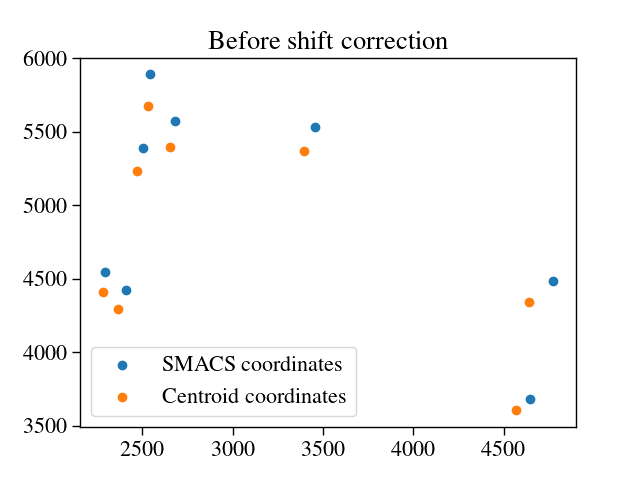

In [8]:
print("Calculating alignment object centroids...")

# Grab pixel coordinates of alignment objects
x_init = y_init = []
for ID in Align.keys():
    pixels = wcs.world_to_pixel(
        SkyCoord(ra=Align[ID]["Align"]["RA"], dec=Align[ID]["Align"]["Dec"])
    )
    x_init = x_init + [pixels[0]]
    y_init = y_init + [pixels[1]]
# Find their centroids using these coordinates as initial estimates
x_init = np.array(x_init)
y_init = np.array(y_init)
x, y = centroid_sources(
    Longlist["sw_F090W"]["sci"]["data"],
    x_init,
    y_init,
    box_size=21,
    centroid_func=centroid_2dg,
)

print("Calculating shifts...")

x_shift = x - x_init
y_shift = y - y_init
shift_total = np.sqrt((x_shift) ** 2 + (y_shift) ** 2)
# Exaggerate offsets visually for plotting
x_shift_plot = x_init + 100 * x_shift
y_shift_plot = y_init + 100 * y_shift

print("Plotting shifts...")

plt.close("all")
plt.scatter(x_init, y_init, label="SMACS coordinates")
plt.scatter(x_shift_plot, y_shift_plot, label="Centroid coordinates")
plt.legend(frameon=True)
plt.title("Before shift correction")

print("Done.")

### Pixel Scaling

Clearly, there is a systematic offset. We will subtract this out, and then determine if there is any systematic pixel scaling issue. (The latter should look as if the sources are pointing towards a particular location on the sky.)

Subtracting shifts...
Finding average scaling centre...
Plotting shifted positions...
Done.


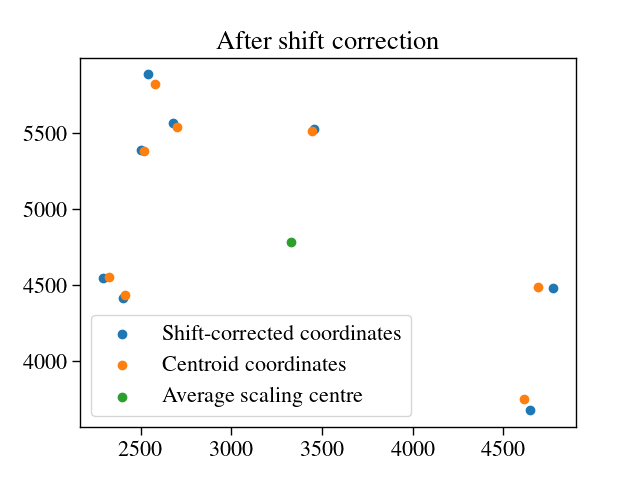

In [9]:
print("Subtracting shifts...")

x_subtr = x_init + np.mean(x_shift)
y_subtr = y_init + np.mean(y_shift)

# Exaggerate offsets visually for plotting
x_shift_new = x - x_subtr
y_shift_new = y - y_subtr
x_shift_new_plot = x_subtr + 100 * x_shift_new
y_shift_new_plot = y_subtr + 100 * y_shift_new

print("Finding average scaling centre...")

# Function to find equation of a line
def linear_equation(x1, x2, y1, y2):
    m = (y1 - y2) / (x1 - x2)
    c = -m * x1 + y1
    return m, c


# Function to find intersect between two lines
def intersect(m1, c1, m2, c2):
    x_int = (c2 - c1) / (m1 - m2)
    y_int = (m1 * x_int) + c1
    return x_int, y_int


# Using lines given by centroids and predicted locations, find all possible intersection points
x_ints = y_ints = []
for i in range(0, len(x), 1):
    for j in range(0, len(y), 1):
        if i != j:
            mi, ci = linear_equation(x[i], x_subtr[i], y[i], y_subtr[i])
            mj, cj = linear_equation(x[j], x_subtr[j], y[j], y_subtr[j])
            x_int, y_int = intersect(mi, ci, mj, cj)
            x_ints = x_ints + [x_int]
            y_ints = y_ints + [y_int]

# Get the average intersection and plot location
x_int = np.mean(x_ints)
y_int = np.mean(y_ints)

print("Plotting shifted positions...")

plt.close("all")
plt.scatter(x_subtr, y_subtr, label="Shift-corrected coordinates")
plt.scatter(x_shift_new_plot, y_shift_new_plot, label="Centroid coordinates")
plt.scatter(x_int, y_int, label="Average scaling centre")
plt.legend(frameon=True)
plt.title("After shift correction")

print("Done.")

### Final Result

Correcting for scaling...
Plotting scale-corrected reference...
Done.


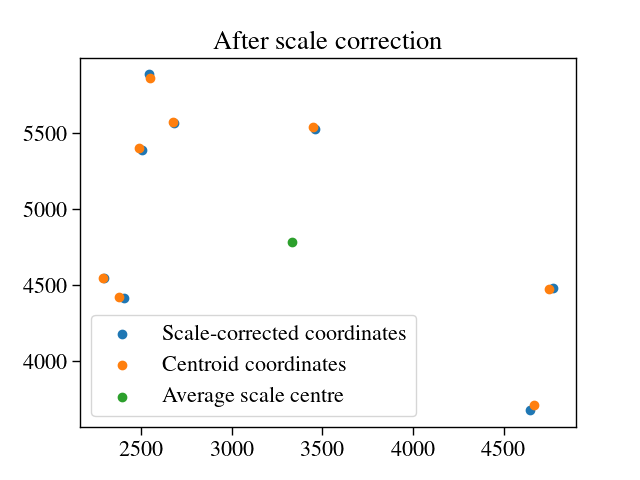

In [10]:
print("Correcting for scaling...")


# Function to find rescaling factor
def find_scale(xs, ys, x_offs, y_offs, x_int, y_int):
    x_intarr = np.full(len(xs), x_int)
    x_dists = xs - x_intarr
    x_offdists = x_offs - x_intarr
    x_scalearr = np.divide(x_offdists, x_dists)
    x_scale = np.mean(x_scalearr)
    y_intarr = np.full(len(ys), y_int)
    y_dists = ys - y_intarr
    y_offdists = y_offs - y_intarr
    y_scalearr = np.divide(y_offdists, y_dists)
    y_scale = np.mean(y_scalearr)
    return x_scale, y_scale


# Function to perform rescaling on sources
def scale_correct(xs, ys, x_scale, y_scale, x_int, y_int):
    x_intarr = np.full(len(xs), x_int)
    y_intarr = np.full(len(ys), y_int)
    x_new = (xs - x_intarr) * x_scale + x_intarr
    y_new = (ys - y_intarr) * y_scale + y_intarr
    return x_new, y_new



x_scale, y_scale = find_scale(x_subtr, y_subtr, x, y, x_int, y_int)
x_new, y_new = scale_correct(x_subtr, y_subtr, x_scale, y_scale, x_int, y_int)

print("Plotting scale-corrected reference...")

x_scale_new = x - x_new
y_scale_new = y - y_new
x_scale_new_plot = x_new + 100 * x_scale_new
y_scale_new_plot = y_new + 100 * y_scale_new

plt.close("all")
plt.scatter(x_new, y_new, label="Scale-corrected coordinates")
plt.scatter(x_scale_new_plot, y_scale_new_plot, label="Centroid coordinates")
plt.scatter(x_int, y_int, label="Average scale centre")
plt.legend(frameon=True)
plt.title("After scale correction")

print("Done.")

### Effect on Aperture

Now that we have our corrections, we can reposition our aperture centroids appropriately. The difference will be subtle but enough to alter the results.

Correcting test aperture...

Defining offset aperture...
Aperture: RectangularAperture
positions: [3072.50609021, 5671.25018561]
w: 6.668164706306727
h: 15.333719194497746
theta: 308.9642034 deg

Defining shifted aperture...
Aperture: RectangularAperture
positions: [3072.61362754, 5670.92148643]
w: 6.668164704094595
h: 15.333719196053098
theta: 308.9642034 deg

Plotting apertures...
Done.


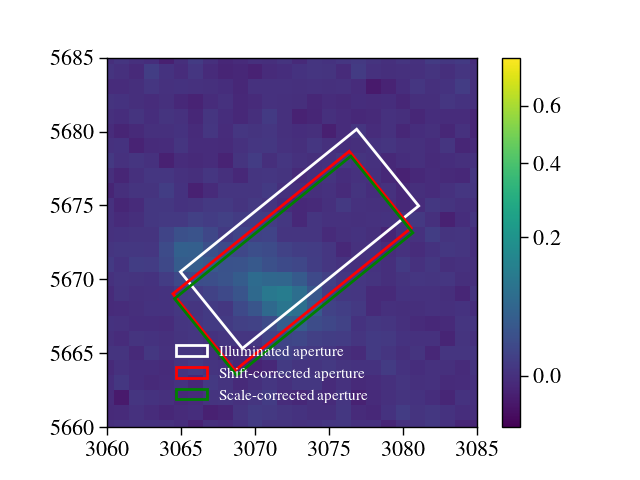

In [11]:
print("Correcting test aperture...")

# Correct aperture centres
aperture_shifted_x = aperture_phys_centroid[0] + np.mean(x_shift)
aperture_shifted_y = aperture_phys_centroid[1] + np.mean(y_shift)
aperture_scaled_x, aperture_scaled_y = scale_correct(
    np.array([aperture_shifted_x]),
    np.array([aperture_shifted_y]),
    x_scale,
    y_scale,
    x_int,
    y_int,
)


aperture_shift_centroid_world = (
    np.array(wcs.pixel_to_world_values(aperture_shifted_x, aperture_shifted_y)) * u.degree
)
aperture_scale_centroid_world = (
    np.array(wcs.pixel_to_world_values(aperture_scaled_x[0], aperture_scaled_y[0]))
    * u.degree
)

print("\nDefining offset aperture...")
centroid_shift_coords_pixels, aperture_shift_illum_corners = Find_Aperture(
    center_offset, aperture_shift_centroid_world, aperture_illum_dims
)
(
    aperture_shift_illum,
    aperture_shift_illum_centroid,
    aperture_shift_illum_width_pixel,
    aperture_shift_illum_height_pixel,
) = aperture_define(aperture_shift_illum_corners, aperture_theta)
print(aperture_shift_illum)

print("\nDefining shifted aperture...")
centroid_scale_coords_pixels, aperture_scale_illum_corners = Find_Aperture(
    center_offset, aperture_scale_centroid_world, aperture_illum_dims
)
(
    aperture_scale_illum,
    aperture_scale_illum_centroid,
    aperture_scale_illum_width_pixel,
    aperture_scale_illum_height_pixel,
) = aperture_define(aperture_scale_illum_corners, aperture_theta)
print(aperture_scale_illum)

print("\nPlotting apertures...")

x_source, y_source = centroid_sources(
    Longlist["sw_F200W"]["sci"]["data"],
    source_coords_pixels[0],
    source_coords_pixels[1],
    box_size=21,
    centroid_func=centroid_2dg,
)
source_scaled_x, source_scaled_y = scale_correct(
    np.array([source_coords_pixels[0] + np.mean(x_shift)]),
    np.array([source_coords_pixels[1] + np.mean(y_shift)]),
    x_scale,
    y_scale,
    x_int,
    y_int,
)

plt.close("all")
norm = simple_norm(Longlist["sw_F200W"]["sci"]["data"], "sqrt", percent=99)
plt.imshow(Longlist["sw_F200W"]["sci"]["data"], norm=norm, interpolation="nearest")
plt.xlim(3060, 3085)
plt.ylim(5660, 5685)

ap_patches = aperture_illum.plot(color="white", lw=2, label="Illuminated aperture")
ap_patches2 = aperture_shift_illum.plot(
    color="red", lw=2, label="Shift-corrected aperture"
)
ap_patches3 = aperture_scale_illum.plot(
    color="green", lw=2, label="Scale-corrected aperture"
)
handles = (ap_patches[0], ap_patches2[0], ap_patches3[0])
plt.legend(
    loc=(0.17, 0.05),
    facecolor="#458989",
    labelcolor="white",
    handles=handles,
    prop={"weight": "bold", "size": 11},
)
plt.colorbar()

print("Done.")

## Calculating Apodised Photometry

Lastly, we can perform our aperture photometry. We want to calculate the total flux through the aperture and then subtract the background flux. This can be done in one of two ways:
1. Using an annulus to estimate the background flux.
2. Identical to 1, but using a sigma-threshold to remove other sources from contributing to the background.

Additionally, we can estimate the flux error using the error extension. One can also use a Poisson error calculation if the error image does not already account for this. We will output all possible values below and the final code allows you to choose between these (default are the sigma-subtracted background and the non-Poisson error calculation).

In [12]:
print("Calculating background flux...")

# Simple mean
data = Longlist["sw_F090W"]["sci"]["data"]
error = Longlist["sw_F090W"]["err"]["data"]
annulus = photutils.aperture.CircularAnnulus(
    np.array([source_scaled_x[0], source_scaled_y[0]]), r_in=30, r_out=50
)
annu_stats = photutils.ApertureStats(data, annulus)
bkg_mean = annu_stats.mean

phot_table = photutils.aperture_photometry(data, aperture_scale_illum)
for col in phot_table.colnames:
    phot_table[col].info.format = "%.8g"  # for consistent table output
aperture_area = aperture_scale_illum.area_overlap(data)

total_bkg = bkg_mean * aperture_area
print("1. Total aperture flux: ", phot_table["aperture_sum"][0])
phot_bkgsub = phot_table["aperture_sum"] - total_bkg

phot_table["total_bkg"] = total_bkg
phot_table["aperture_sum_bkgsub"] = phot_bkgsub
for col in phot_table.colnames:
    phot_table[col].info.format = "%.8g"  # for consistent table output
print("2. Simple background-subtracted flux: ", phot_bkgsub[0])
print("3. Simple background: ", total_bkg)

# Sigma-clipped mean
# Define sigma-clipping rules
sigclip = SigmaClip(sigma=3.0, maxiters=10)

# Calculate statistics in aperture and annulus
aper_stats = photutils.ApertureStats(data, aperture_scale_illum, sigma_clip=None)
bkg_stats = photutils.ApertureStats(data, annulus, sigma_clip=sigclip)

# Calculate total background flux in aperture
total_bkg = bkg_stats.median * aper_stats.sum_aper_area.value
# print(bkg_stats.median)

# Find total flux after subtraction
apersum_bkgsub = aper_stats.sum - total_bkg

print("4. Sigma-clipped background-subtracted flux: ", apersum_bkgsub)
print("5. Sigma-clipped background: ", total_bkg)

phot_table = photutils.aperture_photometry(data, aperture_scale_illum, error=error)
for col in phot_table.colnames:
    phot_table[col].info.format = "%.8g"  # for consistent table output
print("6. Non-poisson flux error: ", phot_table["aperture_sum_err"][0])

effective_gain = Longlist["sw_F200W"]["header"]["EFFEXPTM"]  # if flux is electrons/s, then this gives total electrons
bkg_error = calc_total_error(data, error, effective_gain)
phot_table = photutils.aperture_photometry(data, aperture_scale_illum, error=bkg_error)
for col in phot_table.colnames:
    phot_table[col].info.format = "%.8g"  # for consistent table output
print("7. Flux error including poisson error: ", phot_table["aperture_sum_err"][0])
print("Done.")

Calculating background flux...
1. Total aperture flux:  0.06555454740128833
2. Simple background-subtracted flux:  -0.0008894907537262964
3. Simple background:  0.06644403815501462
4. Sigma-clipped background-subtracted flux:  0.01181858249760423
5. Sigma-clipped background:  0.0537359649036841
6. Non-poisson flux error:  0.06826082374928609
7. Flux error including poisson error:  0.0685052376823962
Done.


# (UNUSED) GAIA Queries

_This section ultimately not used, as there were too few alignment stars to make sense of the results. Kept as appendix demonstrating how to query the GAIA database._

Now, we want to query these sources in GAIA, and test whether there is a systematic astrometry offset (as seems apparent in Aladin). We will use the astroquery package for this.

First, we will match our alignment stars to the GAIA database, then attempt to match our other sources.

In [ ]:
Gaia.ROW_LIMIT = -1
Region = SkyCoord(
    ra=110.8640599, dec=-73.45689639, unit=(u.degree, u.degree), frame="icrs"
)
Radius = u.Quantity(0.1, u.deg)
Results = (Gaia.cone_search_async(Region, Radius)).get_results()

In [ ]:
for galaxy in Align.keys():
    for x in range(0, len(Results), 1):
        if x == 0:
            RA = Results[x]["ra"] * u.degree
            Dec = Results[x]["dec"] * u.degree
            ID = Results[x]["source_id"]
            Row = x
        else:
            if np.sqrt(
                (Align[galaxy]["Align"]["RA"] - Results[x]["ra"] * u.degree) ** 2
                + (Align[galaxy]["Align"]["Dec"] - Results[x]["dec"] * u.degree) ** 2
            ) < np.sqrt(
                (Align[galaxy]["Align"]["RA"] - RA) ** 2
                + (Align[galaxy]["Align"]["Dec"] - Dec) ** 2
            ):
                RA = Results[x]["ra"] * u.degree
                Dec = Results[x]["dec"] * u.degree
                ID = Results[x]["source_id"]
                Row = x
    Align[galaxy]["Gaia"] = {}
    Align[galaxy]["Gaia"]["RA"] = RA
    Align[galaxy]["Gaia"]["Dec"] = Dec
    Align[galaxy]["Gaia"]["ID"] = ID
    Align[galaxy]["Gaia"]["Row"] = Row

In [ ]:
def find_nearest(
    array,
    value,
):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


for galaxy in Align.keys():
    RA = find_nearest(np.array(Results["ra"]), Align[galaxy]["Align"]["RA"].value)
    Dec = find_nearest(np.array(Results["dec"]), Align[galaxy]["Align"]["Dec"].value)
    print(
        RA,
        Dec,
        Results[RA]["ra"],
        Results[Dec]["dec"],
        abs(Align[galaxy]["Align"]["RA"].value - Results[RA]["ra"]),
        abs(Align[galaxy]["Align"]["Dec"].value - Results[Dec]["dec"]),
    )

In [ ]:
for galaxy in Align.keys():
    print(
        galaxy,
        Align[galaxy]["Gaia"]["Row"],
        Align[galaxy]["Align"]["RA"].value,
        Align[galaxy]["Align"]["Dec"].value,
        Align[galaxy]["Gaia"]["RA"].value,
        Align[galaxy]["Gaia"]["Dec"].value,
        np.sqrt(
            (Align[galaxy]["Align"]["RA"].value - Align[galaxy]["Gaia"]["RA"].value)
            ** 2
            + (Align[galaxy]["Align"]["Dec"].value - Align[galaxy]["Gaia"]["Dec"].value)
            ** 2
        ),
    )

In [ ]:
Results.write("../Working_Directory/GAIA_Search.csv")